In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.model_selection import ParameterGrid, GridSearchCV
from tqdm import tqdm
from itertools import product

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb

# needed for nltk english text processing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/imosia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imosia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/imosia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/imosia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/imosia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# About the Project 
This is (Kaggle Competition)[https://www.kaggle.com/c/learn-ai-bbc/overview] about text document classification.  

**Information from Kaggle:**  

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using **Accuracy** as a metric.  

(Recommended Reading)[https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification]

# The Data  
We will upload and learn the data.  

In [21]:
# loading the data
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv('BBC News Test.csv')

print(train_df.shape)
print(test_df.shape)

(1490, 3)
(735, 2)


In [22]:
display(train_df.head())
display(test_df.head())

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness. cynthia cooper worldcom s ex-head of internal accounting alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy. prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper who now runs her own consulting business told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a green light to the procedures and practices used by worldcom. mr ebber s lawyers have said he was unaware of the fraud arguing that auditors did not alert him to any problems. ms cooper also said that during shareholder meetings mr ebbers often passed over technical questions to the company s finance chief giving only brief answers himself. the prosecution s star witness former worldcom financial chief scott sullivan has said that mr ebbers ordered accounting adjustments at the firm telling him to hit our books . however ms cooper said mr sullivan had not mentioned anything uncomfortable about worldcom s accounting during a 2001 audit committee meeting. mr ebbers could face a jail sentence of 85 years if convicted of all the charges he is facing. worldcom emerged from bankruptcy protection in 2004 and is now known as mci. last week mci agreed to a buyout by verizon communications in a deal valued at $6.75bn.,business
1,154,german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy. munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up. we re surprised that the ifo index has taken such a knock said dz bank economist bernd weidensteiner. the main reason is probably that the domestic economy is still weak particularly in the retail trade. economy and labour minister wolfgang clement called the dip in february s ifo confidence figure a very mild decline . he said that despite the retreat the index remained at a relatively high level and that he expected a modest economic upswing to continue. germany s economy grew 1.6% last year after shrinking in 2003. however the economy contracted by 0.2% during the last three months of 2004 mainly due to the reluctance of consumers to spend. latest indications are that growth is still proving elusive and ifo president hans-werner sinn said any improvement in german domestic demand was sluggish. exports had kept things going during the first half of 2004 but demand for exports was then hit as the value of the euro hit record levels making german products less competitive overseas. on top of that the unemployment rate has been stuck at close to 10% and manufacturing firms including daimlerchrysler siemens and volkswagen have been negotiating with unions over cost cutting measures. analysts said that the ifo figures and germany s continuing problems may delay an interest rate rise by the european central bank. eurozone interest rates are at 2% but comments from senior officials have recently focused on the threat of inflation prompting fears that interest rates may rise.,business
2,1101,bbc poll indicates economic gloom citizens in a majority of nations surveyed in a bbc world service

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan. day has been displaced by the arrival of simon royce who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said: some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton. but i have other irons in the fire. i have had a yes from a couple of others should i need them. day s rangers contract expires in the summer. meanwhile holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.
1,1319,software watching while you work software that can not only monitor every keystroke and action performed at a pc but also be used as legally binding evidence of wrong-doing has been unveiled. worries about cyber-crime and sabotage have prompted many employers to consider monitoring employees. the developers behind the system claim it is a break-through in the way data is monitored and stored. but privacy advocates are concerned by the invasive nature of such software. the system is a joint venture between security firm 3ami and storage specialists bridgehead software. they have joined forces to create a system which can monitor computer activity store it and retrieve disputed files within minutes. more and more firms are finding themselves in deep water as a result of data misuse. sabotage and data theft are most commonly committed from within an organisation according to the national hi-tech crime unit (nhtcu) a survey conducted on its behalf by nop found evidence that more than 80% of medium and large companies have been victims of some form of cyber-crime. bridgehead software has come up with techniques to prove to a legal standard that any stored file on a pc has not been tampered with. ironically the impetus for developing the system came as a result of the freedom of information act which requires companies to store all data for a certain amount of time. the storage system has been incorporated into an application developed by security firm 3ami which allows every action on a computer to be logged. potentially it could help employers to follow the trail of stolen files and pinpoint whether they had been emailed to a third party copied printed deleted or saved to cd floppy disk memory stick or flash card. other activities the system can monitor include the downloading of pornography the use of racist or bullying language or the copying of applications for personal use. increasingly organisations that handle sensitive data such as governments are using biometric log-ins such as fingerprinting to provide conclusive proof of who was using a particular machine at any given time. privacy advocates are concerned that monitoring at work is not only damaging to employee s privacy but also to the relationship between employers and their staff. that is not the case said tim ellsmore managing director of 3ami. it is not about replacing dialogue but there are issues that you can talk through but you still need proof he said. people need to recognise that you are using a pc as a representative of a company and that employers have a legal requirement to store data he added.
2,1138,d arcy injury adds to ireland woe gordon d arcy has been ruled out of the ireland team for saturday s six nations clash against scotland in murrayfield. like skipper brian o driscoll d arcy failed to recover from a hamstring injury. the side will now be led by munster lock paul o connell. shane horgan switches from wing to centre where he will be joined by ulster s kevin maggs. girvan dempsey comes into the team to take the right wing spot while gavin duffy is called up to the replacements. we gave gordon

In [23]:
# We need articleId for submitting the test predictions, but not for training.
train_df.drop(columns=['ArticleId'], inplace=True)
test_article_ids = test_df['ArticleId']
test_df.drop(columns=['ArticleId'], inplace=True)

In [24]:
# missing and duplicate values
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

Text        0
Category    0
dtype: int64
Text    0
dtype: int64
50
13


<Axes: title={'center': 'Category Distribution in Training Set'}, xlabel='Category'>

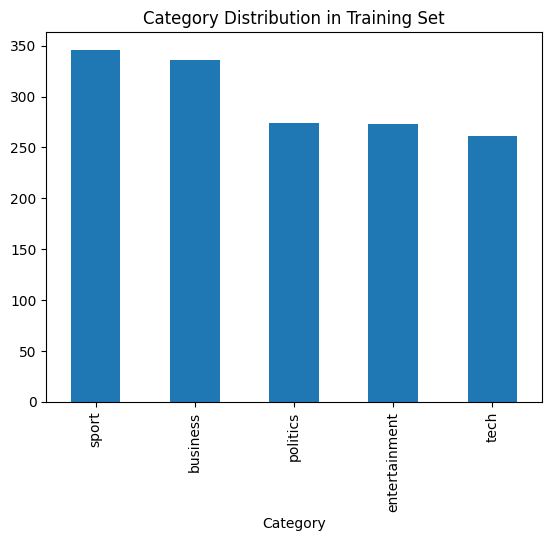

In [25]:
train_df['Category'].value_counts().plot(kind='bar', title='Category Distribution in Training Set')

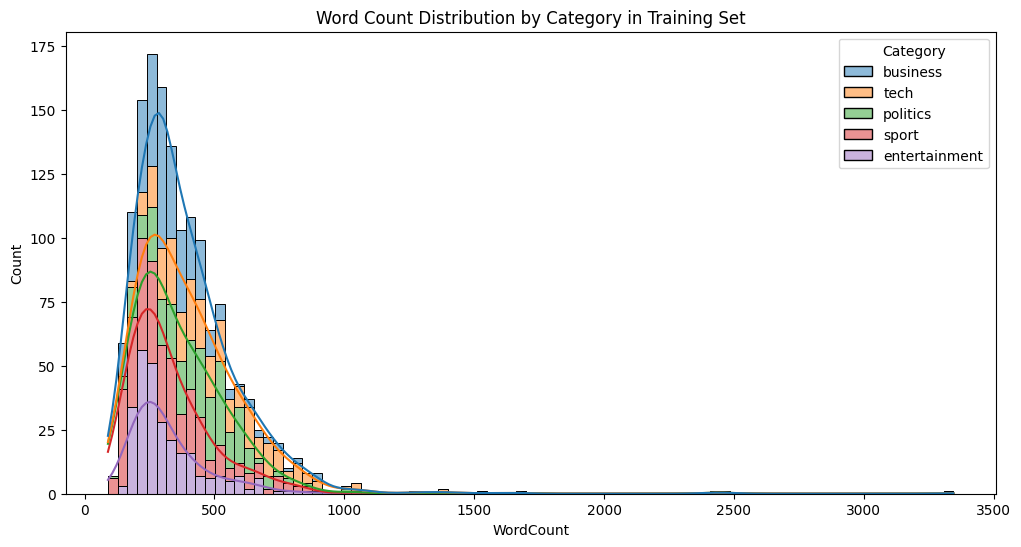

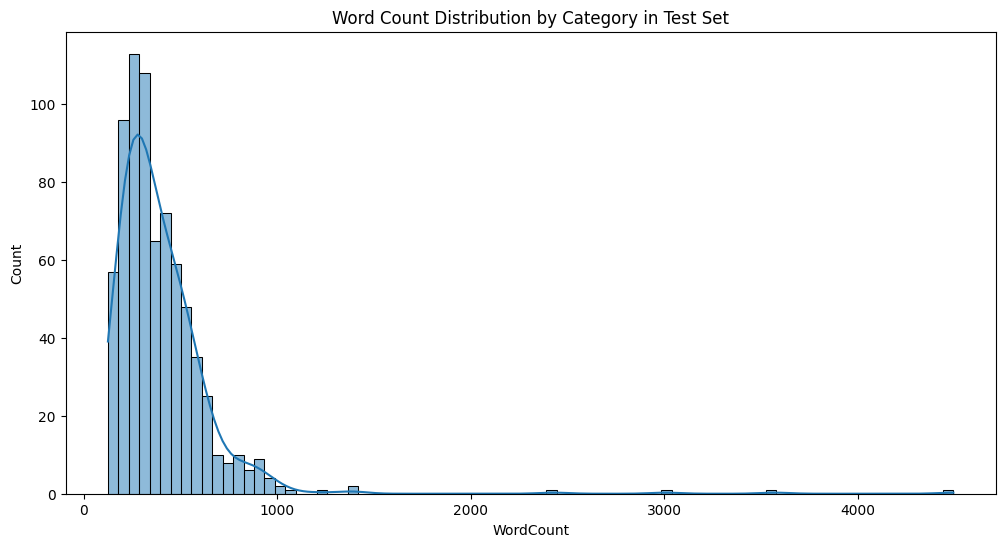

In [26]:
train_df['WordCount'] = train_df['Text'].apply(lambda x: len(x.split()))
test_df['WordCount'] = test_df['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='WordCount', hue='Category', kde=True, multiple='stack')
plt.title('Word Count Distribution by Category in Training Set')
plt.figure(figsize=(12, 6))
sns.histplot(data=test_df, x='WordCount', kde=True, multiple='stack')
plt.title('Word Count Distribution by Category in Test Set')
plt.show()

test_df.drop(columns=['WordCount'], inplace=True)
train_df.drop(columns=['WordCount'], inplace=True)

In [27]:
pd.set_option('display.max_colwidth', None) 
print(train_df['Text'].head())

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [28]:
%%time

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)
train_df['Text'] = train_df['Text'].apply(preprocess_text)
test_df['Text'] = test_df['Text'].apply(preprocess_text)

CPU times: user 4.8 s, sys: 353 ms, total: 5.16 s
Wall time: 6.58 s


In [29]:
print(train_df['Text'].head())

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   worldcom launch defence lawyer defen

In [30]:
unique_words = set(' '.join(train_df['Text']).split())
print(f'Number of unique words in the training set: {len(unique_words)}')

Number of unique words in the training set: 20483


In [31]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, norm='l2', ngram_range=(1, 2))
train_tfidf = tfidf_vectorizer.fit_transform(train_df['Text'])
test_tfidf = tfidf_vectorizer.transform(test_df['Text'])
print(f'Train TF-IDF shape: {train_tfidf.shape}')
print(f'Test TF-IDF shape: {test_tfidf.shape}')

print(train_tfidf[0:5, 0:10].todense())

Train TF-IDF shape: (1490, 9669)
Test TF-IDF shape: (735, 9669)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.02216155
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


## Summary of EDA  

During the EDA part of the studies:  
- Dataframes were checked for missing values and duplicates (none were found)  
- Text was preprocessed with lemmatization and stopwords removal  
- Lenght of texts has similar distribution for all the catgories and test dataset, there are some lenghier texts, but this should not posses a problem for this type of research  
- Distirution of categories (target) was found to be aprox even over the training data  
- The texts were then vectorized using TfidfVectorizer, there are 9669 unigram and bigrams with count > 5 on traind df  

# Unsupervised Learning  
We will ommit for now knowledge about the categories to test how unsupervised learning can handle this task.

In [32]:
# helper function for permutation of the labels

def label_permute_compare(ytdf,yp,n=5):
    """
    Implemented in the Lab 2 of the course.
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    best_score = 0
    best_permutation = None
    unique_labels = ytdf['Category'].unique()

    for perm in itertools.permutations(unique_labels):
        label_mapping = {old_label: new_label for old_label, new_label in enumerate(perm)}

        yp_permuted = np.array([label_mapping[label] for label in yp])

        score = accuracy_score(ytdf, yp_permuted)

        if score > best_score:
            best_score = score
            best_permutation = perm

    return best_permutation, best_score

def predict_test_with_train_permutation(train_permutation, test_probs):
    """
    Predicts the test set labels using the training set label permutation.
    """
    label_mapping = {old_label: new_label for old_label, new_label in enumerate(train_permutation)}
    yp_test_permuted = np.array([label_mapping[label] for label in test_probs])
    return yp_test_permuted

In [33]:
%%time

list_of_models = ['SVD', 'NMF', 'LDA']
list_of_model_objects = [TruncatedSVD, NMF, LatentDirichletAllocation]

def run_model(model_name, model_object, train_data, test_data, train_labels):
    """
    Function to run a model, predict and evaluate
    """
    model = model_object(n_components=5, random_state=42) # we know that there are 5 classes

    model.fit(train_data) 
    train_transformed = model.transform(train_data)
    test_transformed = model.transform(test_data)
    
    train_pred = np.argmax(train_transformed, axis=1)
    test_pred = np.argmax(test_transformed, axis=1)
    
    train_permutation, train_accuracy = label_permute_compare(train_labels, train_pred)

    test_df_for_submission = pd.DataFrame({
        'ArticleId': test_article_ids,
        'Category': predict_test_with_train_permutation(train_permutation, test_pred)
    })
    test_df_for_submission.to_csv(f'{model_name}_submission.csv', index=False)

    print(f'Model: {model_name} | Train Accuracy: {train_accuracy:.4f}')


for model_name, model_object in zip(list_of_models, list_of_model_objects):
    run_model(model_name, model_object, train_tfidf, test_tfidf, train_df[['Category']])

Model: SVD | Train Accuracy: 0.3604
Model: NMF | Train Accuracy: 0.9262
Model: LDA | Train Accuracy: 0.4966
CPU times: user 6.48 s, sys: 210 ms, total: 6.69 s
Wall time: 3.67 s


In [34]:
%%time
hyperparams_grid = {
    'solver': ['cd', 'mu'],
    'beta_loss': ['frobenius', 'kullback-leibler', 'itakura-saito'],
    'init': ['random', 'nndsvd', 'nndsvda', 'nndsvdar'],
    'alpha_W': [0.0, 0.1, 0.5],
    'alpha_H': [0.0, 0.1, 0.5],
    'max_iter': [200, 500]
}

keys, values = zip(*hyperparams_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

results = pd.DataFrame(columns=['Model_object', 'Params', 'Train_Accuracy', 'Permutation'])

counter_wrong_params_combinations = 0

for params in tqdm(param_combinations, desc="Grid Search"):
    try:
        model = NMF(n_components=5
                    , solver=params['solver']
                    , beta_loss=params['beta_loss']
                    , init=params['init']
                    , alpha_W=params['alpha_W']
                    , alpha_H=params['alpha_H']
                    , max_iter=params['max_iter']).fit(train_tfidf)

        y_pred = model.transform(train_tfidf)
        train_permutation, train_accuracy = label_permute_compare(train_df[['Category']], y_pred.argmax(axis=1))
        
        results = pd.concat([results, pd.DataFrame({
            'Model_object': model,
            'Params': str(params),
            'Train_Accuracy': train_accuracy,
            'Permutation': str(train_permutation)
        }, index=[0])], ignore_index=True)

    except Exception as e:
        counter_wrong_params_combinations += 1

print(f"Total wrong parameter combinations: {counter_wrong_params_combinations}")


Grid Search: 100%|██████████| 432/432 [05:13<00:00,  1.38it/s]

Total wrong parameter combinations: 216
CPU times: user 8min 48s, sys: 35.3 s, total: 9min 23s
Wall time: 5min 13s


In [35]:
display(results.sort_values(by='Train_Accuracy', ascending=False).head())

,Model_object,Params,Train_Accuracy,Permutation
187,"NMF(alpha_H=0.0, alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvda',\n max_iter=500, n_components=5, solver='mu')","{'solver': 'mu', 'beta_loss': 'kullback-leibler', 'init': 'nndsvda', 'alpha_W': 0.1, 'alpha_H': 0.0, 'max_iter': 500}",0.965772,"('sport', 'politics', 'tech', 'entertainment', 'business')"
186,"NMF(alpha_H=0.0, alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvda',\n n_components=5, solver='mu')","{'solver': 'mu', 'beta_loss': 'kullback-leibler', 'init': 'nndsvda', 'alpha_W': 0.1, 'alpha_H': 0.0, 'max_iter': 200}",0.965772,"('sport', 'politics', 'tech', 'entertainment', 'business')"
180,"NMF(alpha_H=0.0, beta_loss='kullback-leibler', init='nndsvda', n_components=5,\n solver='mu')","{'solver': 'mu', 'beta_loss': 'kullback-leibler', 'init': 'nndsvda', 'alpha_W': 0.0, 'alpha_H': 0.0, 'max_iter': 200}",0.964430,"('sport', 'politics', 'tech', 'entertainment', 'business')"
181,"NMF(alpha_H=0.0, beta_loss='kullback-leibler', init='nndsvda', max_iter=500,\n n_components=5, solver='mu')","{'solver': 'mu', 'beta_loss': 'kullback-leibler', 'init': 'nndsvda', 'alpha_W': 0.0, 'alpha_H': 0.0, 'max_iter': 500}",0.964430,"('sport', 'politics', 'tech', 'entertainment', 'business')"
191,"NMF(alpha_H=0.5, alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvda',\n max_iter=500, n_components=5, solver='mu')","{'solver': 'mu', 'beta_loss': 'kullback-leibler', 'init': 'nndsvda', 'alpha_W': 0.1, 'alpha_H': 0.5, 'max_iter': 500}",0.964430,"('sport', 'politics', 'tech', 'entertainment', 'business')"


In [36]:
best_model = results.sort_values(by='Train_Accuracy', ascending=False).iloc[0]
best_model_object = best_model['Model_object']
best_model_permutation = eval(best_model['Permutation'])

test_transformed = best_model_object.transform(test_tfidf)
test_pred = np.argmax(test_transformed, axis=1)

test_df_for_submission = pd.DataFrame({
    'ArticleId': test_article_ids,
    'Category': predict_test_with_train_permutation(best_model_permutation, test_pred)
})
test_df_for_submission.to_csv('Unsupervised_hyperparam_optimized_submission.csv', index=False)

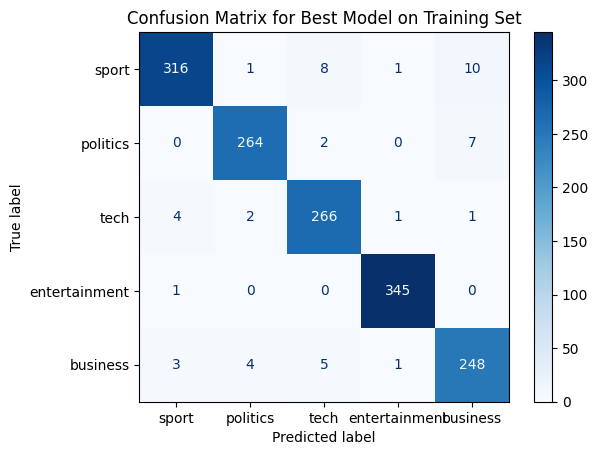

               precision    recall  f1-score   support

        sport       0.98      0.94      0.96       336
     politics       0.97      0.97      0.97       273
         tech       0.95      0.97      0.96       274
entertainment       0.99      1.00      0.99       346
     business       0.93      0.95      0.94       261

     accuracy                           0.97      1490
    macro avg       0.96      0.97      0.96      1490
 weighted avg       0.97      0.97      0.97      1490



In [37]:
prediction_train_best_model = np.argmax(best_model_object.transform(train_tfidf), axis=1)
prediction_train_best_model_mapped_to_categories = [best_model_permutation[label] for label in prediction_train_best_model]
cm = confusion_matrix(train_df['Category'], prediction_train_best_model_mapped_to_categories)
DisplayCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_permutation)
DisplayCM.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Best Model on Training Set')
plt.show()

print(classification_report(train_df['Category'], prediction_train_best_model_mapped_to_categories, target_names=best_model_permutation))

## Reflection on the Unsupervised Learning  
Negative Matrix factorization was the only model which performed reasonable from zero-shot.  
Futher optimization of hyperparametrs for its' training allowed to achieve 0.965 accuracy on the training dataset.  
From the analysis of the prediction, it seems that entertainment is the label which can be easily distingueshed. Others perform similar, while buisiness has more overlaps then others.  
As for the test sumbission on Kaggle the results are following:  
accuracy = 0.92789 for the first shot  
accuracy = 0.95646 for theoptimized vesion  

# Comparing with Supervised Learning  
With the data laready preprocessed one may liek to try supervised learning for the same task.

In [45]:
# multiclass classification for several models and param greads
results = pd.DataFrame(columns=['model', 'best_params', 'best_score', 'time', 'best_model'])

def perform_cross_validation(model_name, model, param_grid, X_train, y_train, results):
    start_time = time.time()

    grid_search = GridSearchCV(model, param_grid, cv=5, verbose=0)
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    total_time = end_time - start_time

    results = pd.concat([results, pd.DataFrame([{
                                'model': model_name,
                                'best_params': grid_search.best_params_, 
                                'best_score': grid_search.best_score_, 
                                'time': total_time,
                                'best_model': grid_search.best_estimator_
                                }])], ignore_index=True)

    return results


# list of hyperparameters for GridSearchCV
tree_param_grid = {'max_depth': [None, 1, 2, 4, 6, 8, 10, 15, 20, 30]}

rf_param_grid = {'n_estimators': [None, 10, 50, 100, 200], 
                 'max_depth': [None, 1, 2, 4, 6, 8, 10, 15],
                 'bootstrap': [True, False]}

knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 21],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

logreg_param_grid = {'C': [0.01, 0.1, 1, 10],
                     'penalty': ['none', 'l2']}

svc_param_grid = {'C': [0.01, 0.1, 1, 10],
                'gamma': [0.01, 0.1, 1, 10]}

lgb_param_grid = {'max_depth': [None, 1, 3, 6, 10, 15],
                    'learning_rate': [None, 0.001, 0.05, 0.2],
                    'n_estimators': [None, 10, 100, 300]} 

extra_trees_param_grid = {'n_estimators': [None, 10, 100, 300],
                          'max_depth': [None, 1, 3, 6, 10, 15],
                          'bootstrap': [True, False]}

ada_boost_param_grid = {'n_estimators': [None, 10, 100, 300],
                       'learning_rate': [None, 0.001, 0.05, 0.2]}



# list of models
models = [DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC()
        , lgb.LGBMClassifier(verbose=-1)
        , ExtraTreesClassifier()
        , AdaBoostClassifier()
        ]

list_of_names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'LogisticRegression'
        , 'SVC', 'LGBMClassifier'
        , 'ExtraTreesClassifier'
        , 'AdaBoostClassifier'
        ]

# list of hyperparameters
param_grids = [tree_param_grid, rf_param_grid, knn_param_grid, logreg_param_grid, svc_param_grid
            , lgb_param_grid
            , extra_trees_param_grid, ada_boost_param_grid]


In [46]:
for model, name, param_grid in tqdm(zip(models, list_of_names, param_grids), total=len(models), desc="Model CV"):
    tqdm.write(f"Starting cross-validation for {name}...")
    try:
        results = perform_cross_validation(name, model, param_grid, train_tfidf, train_df['Category'], results)
    except Exception as e:
        tqdm.write(f"Error during cross-validation for {name}: {e}")
        continue

Model CV:   0%|          | 0/8 [00:00<?, ?it/s]

Starting cross-validation for DecisionTreeClassifier...


Model CV:  12%|█▎        | 1/8 [00:08<01:02,  8.99s/it]

Starting cross-validation for RandomForestClassifier...


Model CV:  25%|██▌       | 2/8 [01:35<05:28, 54.77s/it]

Starting cross-validation for KNeighborsClassifier...


Model CV:  38%|███▊      | 3/8 [01:42<02:43, 32.69s/it]

Starting cross-validation for LogisticRegression...


Model CV:  50%|█████     | 4/8 [02:13<02:08, 32.09s/it]

Starting cross-validation for SVC...


Model CV:  62%|██████▎   | 5/8 [05:42<04:48, 96.01s/it]

Starting cross-validation for LGBMClassifier...


Model CV:  75%|███████▌  | 6/8 [25:25<15:30, 465.46s/it]

Starting cross-validation for ExtraTreesClassifier...


Model CV:  88%|████████▊ | 7/8 [26:19<05:30, 330.88s/it]

Starting cross-validation for AdaBoostClassifier...


Model CV: 100%|██████████| 8/8 [28:42<00:00, 215.36s/it]


In [50]:
pd.set_option('display.max_colwidth', 100)
results = results.sort_values(by='best_score', ascending=False)
display(results.head(10))

,model,best_params,best_score,time,best_model
3,LogisticRegression,"{'C': 10, 'penalty': 'l2'}",0.973826,31.146480,LogisticRegression(C=10)
4,SVC,"{'C': 1, 'gamma': 1}",0.973154,209.274203,"SVC(C=1, gamma=1)"
6,ExtraTreesClassifier,"{'bootstrap': False, 'max_depth': None, 'n_estimators': 300}",0.967114,53.781858,"(ExtraTreeClassifier(random_state=324584527), ExtraTreeClassifier(random_state=1633128342), Extr..."
1,RandomForestClassifier,"{'bootstrap': False, 'max_depth': None, 'n_estimators': 200}",0.966443,86.789166,"(DecisionTreeClassifier(max_features='sqrt', random_state=1359958911), DecisionTreeClassifier(ma..."
2,KNeighborsClassifier,"{'algorithm': 'auto', 'n_neighbors': 21, 'weights': 'distance'}",0.961074,6.390943,"KNeighborsClassifier(n_neighbors=21, weights='distance')"
5,LGBMClassifier,"{'learning_rate': None, 'max_depth': None, 'n_estimators': 100}",0.959732,1182.601443,"LGBMClassifier(learning_rate=None, max_depth=None, verbose=-1)"
7,AdaBoostClassifier,"{'learning_rate': 0.2, 'n_estimators': 300}",0.870470,143.728394,"(DecisionTreeClassifier(max_depth=1, random_state=307672040), DecisionTreeClassifier(max_depth=1..."
0,DecisionTreeClassifier,{'max_depth': None},0.818121,8.959942,DecisionTreeClassifier()


In [49]:
best_model = results.iloc[0]['best_model']
test_predictions = best_model.predict(test_tfidf)
test_df_for_submission = pd.DataFrame({
    'ArticleId': test_article_ids,
    'Category': test_predictions
})
test_df_for_submission.to_csv('Supervised_best_model_submission.csv', index=False)

## Reflection on the supevossed approach  

Supervised learning algorythms performed well.  
Actually, Logistic Regression outperformed unsupervised algorythm with accuracy on test 0.98231 (which is the top results for this Kaggle competition).  
tree-based models had a bit worse performance, probably due to the overwhelming ammount of data.